# Evaluation of the different trained models

In this document, we select the best models encountered during training and evaluate them exhaustively on our test database. Recall here that the training database was formed by $7$ images with $1250$ cells, and that the validation database was formed by $3$ images with $1250$ cells. The test database is formed by $150$ images that are completely independent of the previous $10$. In particular, the test database is formed by 
1. $50$ images with $250$ cells,
2. $50$ images with $750$ cells, and
3. $50$ images with $1250$ cells.

For more information on our training and test database, or to generate them yourself, see [data_simulation.ipynb](./data_simulation.ipynb).

# Index
1. Selecting and loading the best models    
    1. [Importing libraries](#libs) to analyze the results and evaluate the models    
    2. Loading and [plotting training information](#plot_train) (training and validation loss)
    3. [Loading the best models](#load_best) encountered through training (in terms of validation loss)
2. Evaluation of the trained models in terms of losses and detection metrics
    1. Definition of detection metrics    
        1. [Optimal F1-score](#optimal_f1) for weighted detections    
        2. [F1-Score for simple detections](#simple_f1)    
    2. [Compute losses and detection metrics](#results) in the test database  
    3. Report [loss statistics](#loss_results) through test database    
    4. Report [detection statistics](#detect_results) through test database
    

# Selecting and loading the best models

<a id="libs"></a>
## Importing libraries to analyze the results and evaluate the models

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max

# For the interested reader, this package was used as a basis to 
# turn the matplotlib plots below into tikz figures for the paper.
# import matplotlib2tikz as plt2tikz

<a id="plot_train"></a>
## Loading and plotting training information (training and validation loss)

Here, the reported train loss is on the random batch chosen at each iteration (formed by a single training image), while the reported validation loss is the average loss on the three validation images.

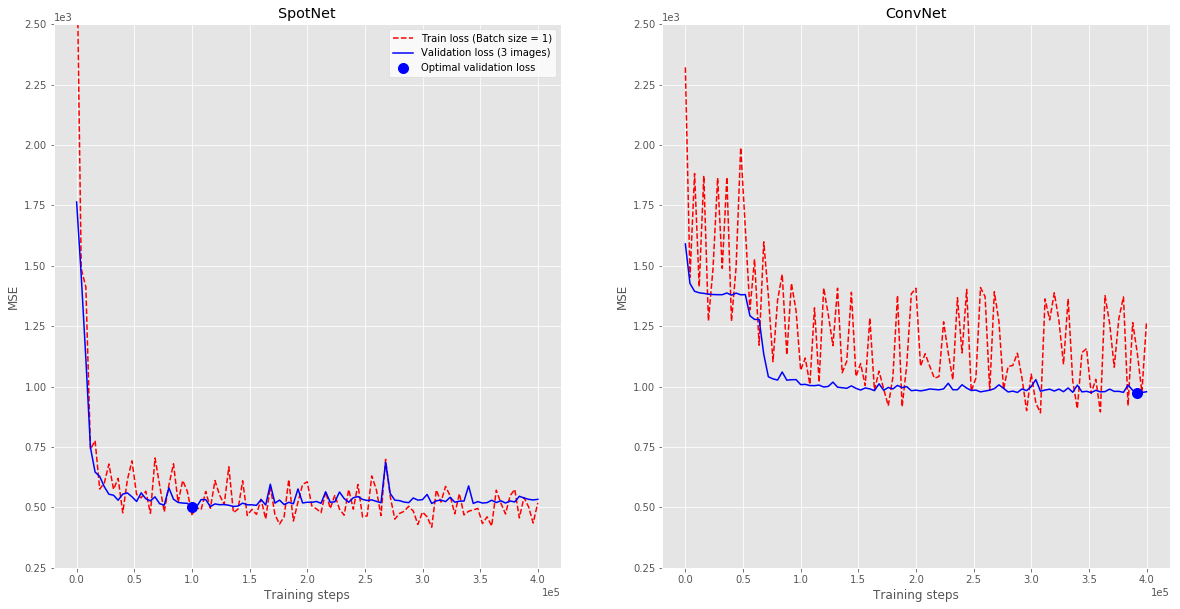

In [2]:
# Select which results to load, the ones provided by the authors or the ones replicated by the user
own_data = False

# Configure results directory
results_dir = 'results/'

# Load training history run by authors
if ~own_data:
    # Load data for SpotNet
    spotnet_results = np.loadtxt( results_dir + 'trainedbyauthors_spotnet_history_5_kersize.txt' )
    spotnet_iterations_record = spotnet_results[:,0] 
    spotnet_train_loss_record = spotnet_results[:,1] 
    spotnet_val_loss_record   = spotnet_results[:,2]
    # Load data for ConvNet with 5x5 kernels
    convnet_results = np.loadtxt( results_dir + 'trainedbyauthors_convnet_history_5_kersize.txt' )
    convnet_iterations_record = convnet_results[:,0] 
    convnet_train_loss_record = convnet_results[:,1] 
    convnet_val_loss_record   = convnet_results[:,2]
    
# Load training history run by user
else:
    # Load data for SpotNet
    spotnet_results = np.load( results_dir + 'trained_spotnet_history_train-steps_5_kersize.npz' )
    spotnet_iterations_record = spotnet_results['iterations_record']
    spotnet_train_loss_record = spotnet_results['train_loss_record']
    spotnet_val_loss_record   = spotnet_results[  'val_loss_record']
    # Load data for ConvNet
    convnet_results = np.load( results_dir + 'trained_convnet_history_train-steps_5_kersize.npz' )
    convnet_iterations_record = convnet_results['iterations_record']
    convnet_train_loss_record = convnet_results['train_loss_record']
    convnet_val_loss_record   = convnet_results[  'val_loss_record']

# Plot results
plt.figure( figsize = [20,10] ); plt.style.use( "ggplot" ); plt.grid( True )

# First subplot, SpotNet
plt.subplot( 121 )
# Plot curves
plt.plot( spotnet_iterations_record, spotnet_train_loss_record, 'r--' )
plt.plot( spotnet_iterations_record, spotnet_val_loss_record,   'b-' )
# Find optimal and plot it
spotnet_optimal = spotnet_val_loss_record.argmin( )
plt.plot( spotnet_iterations_record[spotnet_optimal], 
          spotnet_val_loss_record[ spotnet_optimal],
          'bo', markersize = 10 )
# Legend
plt.legend( ( 'Train loss (Batch size = 1)', 'Validation loss (3 images)', 
              'Optimal validation loss' ),
            facecolor = 'white' )
# Axis labels
plt.xlabel( 'Training steps' )
plt.ylabel( 'MSE' )
# Y Axis range
plt.ylim( (250, 2500) )
# Title and scientific format for axis
plt.title( 'SpotNet' )
plt.ticklabel_format( style = 'sci', scilimits = (0, 0) )

# Second subplot, ConvNet
plt.subplot( 122 )
# Plot curves
plt.plot( convnet_iterations_record, convnet_train_loss_record, 'r--' )
plt.plot( convnet_iterations_record, convnet_val_loss_record,   'b-' )
# Find optimal and plot it
convnet_optimal = convnet_val_loss_record.argmin( )
plt.plot( convnet_iterations_record[convnet_optimal], 
          convnet_val_loss_record[ convnet_optimal],
          'bo', markersize = 10 )
# Axis labels
plt.xlabel( 'Training steps' )
plt.ylabel( 'MSE' )
# Y Axis range
plt.ylim( (250, 2500) )
# Title and scientific format for axis
plt.title( 'ConvNet' )
plt.ticklabel_format( style = 'sci', scilimits = (0, 0) )

<a id="load_best"></a>
## Loading the best models encountered through training (in terms of validation loss)

In [3]:
# Load models trained by authors
if ~own_data:
    spotnet_predict = tf.contrib.predictor.from_saved_model( results_dir + 
                                                          'trainedbyauthors_spotnet_%d_train-steps_5_kersize/'%(
                                                          spotnet_iterations_record[spotnet_optimal] ) )
    convnet_predict = tf.contrib.predictor.from_saved_model( results_dir + 
                                                          'trainedbyauthors_convnet_%d_train-steps_5_kersize/'%(
                                                          convnet_iterations_record[convnet_optimal] ) )
# Load models trained by user
else:
    spotnet_predict = tf.contrib.predictor.from_saved_model( results_dir + 
                                                          'trained_spotnet_%d_train-steps_5_kersize/'%(
                                                          spotnet_iterations_record[spotnet_optimal] ) )
    convnet_predict = tf.contrib.predictor.from_saved_model( results_dir + 
                                                          'trained_convnet_%d_train-steps_5_kersize/'%(
                                                          convnet_iterations_record[convnet_optimal] ) )
predicts_for_eval = [spotnet_predict, convnet_predict]

INFO:tensorflow:Restoring parameters from results/trainedbyauthors_spotnet_100000_train-steps_5_kersize/variables/variables
INFO:tensorflow:Restoring parameters from results/trainedbyauthors_convnet_392000_train-steps_5_kersize/variables/variables


# Evaluation of the trained models in terms of losses and detection metrics

## Definition of detection metrics

<a id="optimal_f1"></a>
### Optimal F1-score for weighted detections

The standard for the journal papers to measure performance was much more relaxed that straight-up F1 score with a pre-determined threshold. In fact, one would detect local maxima in the image first, and then proceed to find the threshold level that led to the higher possible F1 score. The smart way to do this is to sort detections (local maxima) by "pseudo_likelihood" (mean_estimated_psdrs) value and see how the F1 score changes as we include more and more detections with lower pseudo_likelihood.

Also, it is really important to exclude already-matched target points, or otherwise many different estimated detections could be matched to the same true one. 

In [4]:
# For a pseudo_likelihood image, find local maxima and then get optimal thresholding for 
# their consideration as detections in terms of F1-Score
def optimal_f1_score( pseudo_likelihood, x_target, y_target, tolerance = 3, verbose = 0 ):
    # Find local maxima in image [look at neighborhood!!]
    pos = peak_local_max( pseudo_likelihood )
    x_output = pos[:,0]; y_output = pos[:,1]
    # Extract and sort pseudo-likelihoods (decreasing)
    pseudo_likelihood = pseudo_likelihood[x_output, y_output]
    p_l_order = np.flip( np.argsort( pseudo_likelihood ), axis = 0 )
    pseudo_likelihood = pseudo_likelihood[ p_l_order ]
    # Sort detections similarly
    x_output = x_output[ p_l_order ]
    y_output = y_output[ p_l_order ]
    # Initialize variables to keep track of matching process
    correct_flag = np.zeros( p_l_order.shape )
    target_taken_by = np.empty( x_target.shape ); target_taken_by[:] = np.nan;
    # Matching process
    for index in range( p_l_order.size ):
        # Compute distances to ground truth from the index-th detection
        squared_distances = ( x_output[index] - x_target )**2 + ( y_output[index] - y_target )**2
        # Make sure no previosly selected target point is picked again
        squared_distances[~np.isnan(target_taken_by)] = squared_distances.max()+1
        # Get candidate target for index-th detection
        candidate_index = squared_distances.argmin()
        # Take decision and store results
        if np.sqrt( squared_distances[candidate_index] ) <= tolerance:
            correct_flag[index] = 1
            target_taken_by[candidate_index] = index
        
    # Compute metrics at alll possible thresholding levels
    true_positives  = np.cumsum( correct_flag )
    false_positives = np.arange( 1, p_l_order.size + 1 ) - true_positives
    false_negatives = x_target.size - true_positives
    precision = true_positives / (true_positives + false_positives + np.finfo( np.float32 ).eps )
    recall    = true_positives / (true_positives + false_negatives + np.finfo( np.float32 ).eps )
    f1_score  = 2 * precision * recall / (precision + recall + np.finfo( np.float32 ).eps )
    # Get the best thresholding in terms of F1-Score
    best_cutpoint = f1_score.argmax()
    # Inform user
    if verbose == 2:
        print( "TP: %d, FP: %d, FN: %d, prec: %0.4f, rec: %0.4f, F1: %0.4f, threshold: %4.4f"%(
                true_positives[best_cutpoint], false_positives[best_cutpoint],
                false_negatives[best_cutpoint], precision[best_cutpoint],
                recall[best_cutpoint], f1_score[best_cutpoint], 
                .5*( pseudo_likelihood[best_cutpoint] + pseudo_likelihood[best_cutpoint+1] ) ) )
    elif verbose == 1:
        print( "%0.4f"%( f1_score[best_cutpoint] ), end = ' ' )
    
    return ( f1_score[best_cutpoint], x_output[:best_cutpoint], y_output[:best_cutpoint], correct_flag[:best_cutpoint] )

<a id="simple_f1"></a>
### F1-Score for simple detections

In [5]:
# For a simple list of detections without pseudo-likelihoods, compute F1-Score
def simple_f1_score( x_estimated, y_estimated, x_target, y_target, tolerance = 3, verbose = 0 ):
    # Initialize variables to keep track of matching process
    correct_flag = np.zeros( x_estimated.shape )
    # Matching process
    for index in range( x_target.size ):
        # Compute distances to detections from the index-th ground truth point
        squared_distances = (x_target[index] - x_estimated)**2 + (y_target[index] - y_estimated)**2
        # Make sure no previously selected estimated point is picked again
        squared_distances[correct_flag>0] = squared_distances.max()+1
        # Get candidate estimated point of index-th ground truth
        candidate_index = squared_distances.argmin()
        # Take decision and store results
        if np.sqrt( squared_distances[candidate_index] ) <= tolerance:
            correct_flag[candidate_index] = 1
    
    # Compute metrics
    true_positives  = np.sum( correct_flag )
    false_positives = x_estimated.size - true_positives
    false_negatives = x_target.size - true_positives
    precision = true_positives / (true_positives + false_positives + np.finfo( np.float32 ).eps )
    recall    = true_positives / (true_positives + false_negatives + np.finfo( np.float32 ).eps )
    f1_score  = 2 * precision * recall / (precision + recall + np.finfo( np.float32 ).eps )
    # Inform user
    if verbose == 2:
        print( "TP: %d, FP: %d, FN: %d, prec: %0.4f, rec: %0.4f, F1: %0.4f"%(
                true_positives, false_positives, false_negatives, precision, recall,
                f1_score ) ) 
    elif verbose == 1:
        print( "%0.4f"%( f1_score ), end = ' ' )
    
    return( f1_score )

<a id="results"></a>
## Compute losses and detection metrics in the test database

In [6]:
# Time library to time evaluation
import time

# Relevant directories
data_dir = 'sim_data/'

# Configure parameters that define the test database
nrof_cells_array = np.array( [250, 750, 1250] )
nrof_images = 50

# Pre-allocate for results
f1_scores = np.empty( ( nrof_images, nrof_cells_array.size, len( predicts_for_eval ) ) )
MSE = np.empty( ( nrof_images, nrof_cells_array.size, len( predicts_for_eval ) ) )

# Compute all metrics through the test database
for nrof_cells in nrof_cells_array:
    start = time.time( )
    print( 'Evaluating metrics for images with %d cells...'%( nrof_cells ), end = ' ' )
    # Load dataset
    data = np.load( data_dir + 'result_' + str( nrof_cells ) + '_cells_'+str( nrof_images ) + '_images.npy' )[()]
    # Evaluate for each image
    for image_number in range( nrof_images ):
        # Evaluate performance
        image = np.expand_dims( data['fluorospot'][image_number,...], axis = 0 )
        mean_true_psdr = np.mean( data['psdrs'][image_number,...], axis = 2 )
        # Obtain ground-truth data
        (x_target, y_target) = np.nonzero( mean_true_psdr )
        for predictor_index in range( len( predicts_for_eval ) ):
            # Predict 
            estimated_psdr = predicts_for_eval[predictor_index]( {'image': image} )['psdr']
            MSE[image_number,nrof_cells == nrof_cells_array,predictor_index] = np.mean(
                                                            ( data['psdrs'][image_number,...] -
                                                              estimated_psdr[0,...] )**2 )
            # Compute pseudo-likelihood
            mean_estimated_psdr = np.mean( estimated_psdr[0,...], axis = 2 )
            # Obtain optimally-thresholded local maxima and resulting F1-Score
            f1_scores[image_number,nrof_cells == nrof_cells_array,predictor_index], _, _, _ = optimal_f1_score( mean_estimated_psdr, x_target, y_target )
    print( 'Elapsed: %ds.'%(time.time( )-start) )

# Evaluating human F1-Scores
# Blind categories used to obtain input from human
names = ['Few', 'Some', 'Many']
# Pre-allocate for results
f1_scores_human = np.empty( (1, nrof_cells_array.size) )
print( 'Evaluating F1-Scores for human detections on 1 image of each category...', end = ' ' )
start = time.time( )
for nrof_cells_index in range( nrof_cells_array.size ):
    pos_target_human = np.loadtxt( data_dir + 'human_labeling_simdata/' + str( nrof_cells_array[nrof_cells_index] ) + '_Noi3.txt',
                            delimiter = ',' )
    y_target_human = pos_target_human[:,0]; x_target_human = pos_target_human[:,1]
    pos_estimated_human = np.loadtxt( data_dir + 'human_labeling_simdata/' + names[nrof_cells_index] + '_labeled_' 
                                      + names[nrof_cells_index] + '.txt', delimiter = ',' )
    x_estimated_human = pos_estimated_human[:,0]; y_estimated_human = pos_estimated_human[:,1]
    f1_scores_human[ 0, nrof_cells_index ] = simple_f1_score( x_estimated_human, y_estimated_human, 
                                                             x_target_human, y_target_human )
print( 'Elapsed: %ds.'%(time.time( )-start) )

Evaluating metrics for images with 250 cells... Elapsed: 180s.
Evaluating metrics for images with 750 cells... Elapsed: 225s.
Evaluating metrics for images with 1250 cells... Elapsed: 256s.
Evaluating F1-Scores for human detections on 1 image of each category... Elapsed: 0s.


<a id="loss_results"></a>
## Report loss statistics through test database

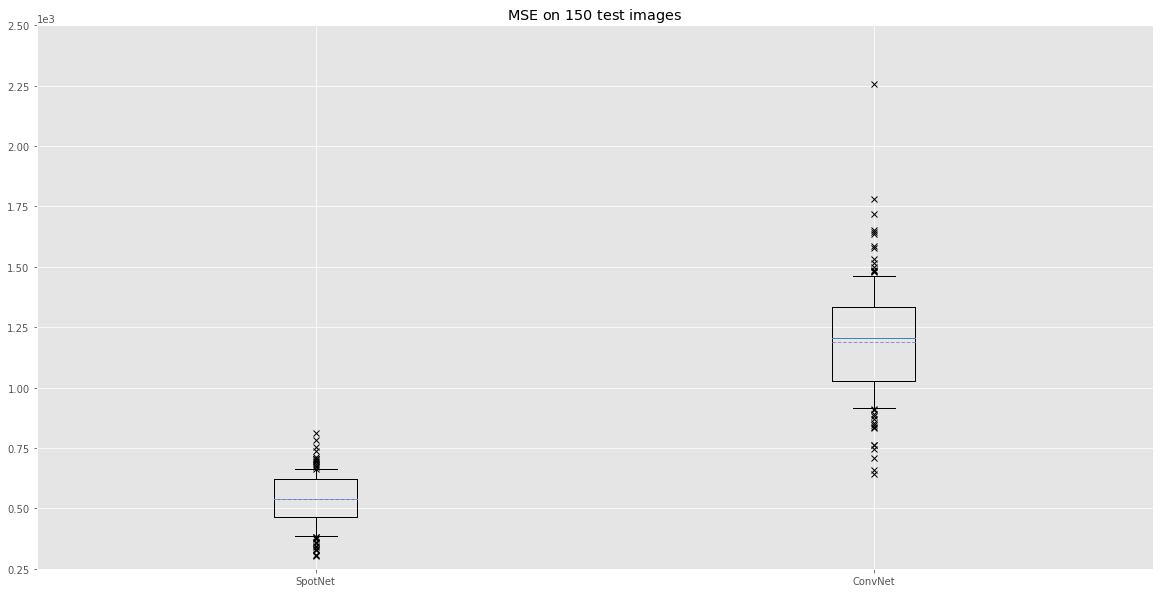

In [7]:
plt.figure( figsize = [20,10] ); ylim = (250, 2500)
plt.grid( True, which = 'minor' )
# Boxplot for 150 test images
plt.boxplot( [np.concatenate( (MSE[:,0,0], MSE[:,1,0], MSE[:,2,0]) ), 
              np.concatenate( (MSE[:,0,1], MSE[:,1,1], MSE[:,2,1]) )], 
             labels = [r"SpotNet", r"ConvNet"], 
             whis = [10, 90], showmeans = True, meanline = True, sym = 'x' );
plt.ticklabel_format( style = 'sci', axis = 'y', scilimits = (0, 0) )
plt.ylim( ylim );
plt.title( r'MSE on $150$ test images' );

<a id="detect_results"></a>
## Report detection statistics through test database

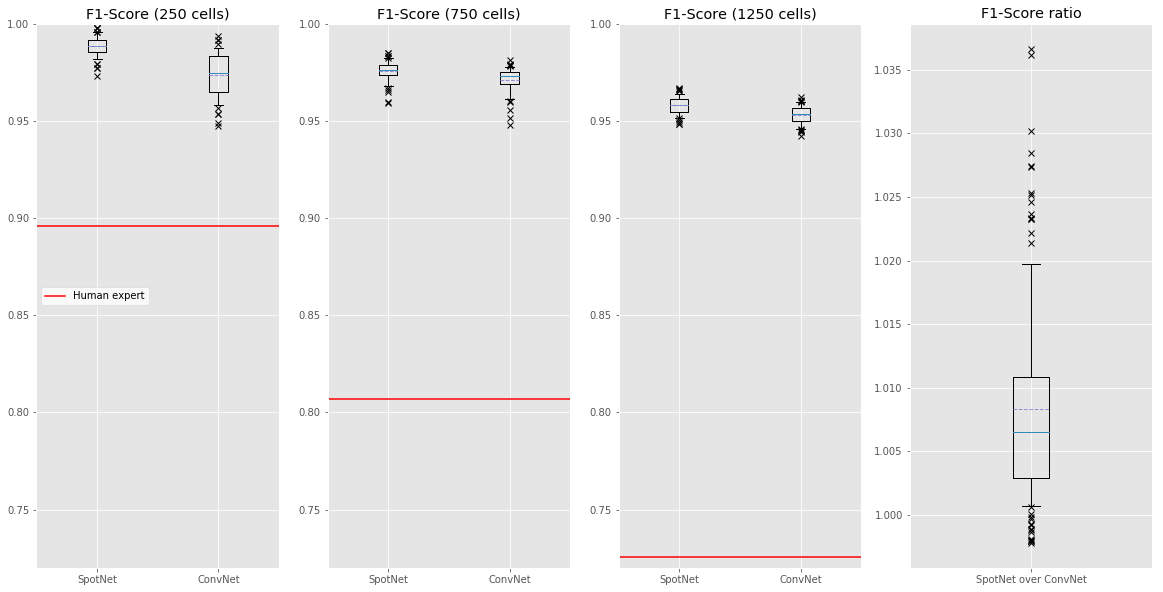

In [8]:
plt.figure( figsize = [20,10] ); ylim = (0.72, 1)
plt.grid( True, which = 'minor' )

# Boxplot for images with 250 cells
plt.subplot( 141 )
plt.boxplot( [f1_scores[:,0,0], f1_scores[:,0,1]], 
             labels = [r"SpotNet", r"ConvNet"], 
             whis = [10, 90], showmeans = True, meanline = True, sym = 'x' );
h = plt.axhline( f1_scores_human[0,0], color = "red" )
plt.ylim( ylim );
plt.title( 'F1-Score (250 cells)' );
plt.legend( (h,), ('Human expert',), facecolor = 'white', loc = "center left"  );

# Boxplot for images with 750 cells
plt.subplot( 142 )
plt.boxplot( [f1_scores[:,1,0], f1_scores[:,1,1]], 
             labels = [r"SpotNet", r"ConvNet"], 
             whis = [10, 90], showmeans = True, meanline = True, sym = 'x' );
plt.axhline( f1_scores_human[0,1], color = "red" )
plt.title( 'F1-Score (750 cells)' );
plt.ylim( ylim );

# Boxplot for images with 1250 cells
plt.subplot( 143 )
plt.boxplot( [f1_scores[:,2,0], f1_scores[:,2,1]], 
             labels = [r"SpotNet", r"ConvNet"], 
             whis = [10, 90], showmeans = True, meanline = True, sym = 'x' );
h = plt.axhline( f1_scores_human[0,2], color = "red" )
plt.title( 'F1-Score (1250 cells)' );
plt.ylim( ylim );

plt.subplot( 144 )
# Boxplot for 150 test images
plt.boxplot( np.concatenate((f1_scores[:,0,0],f1_scores[:,1,0],f1_scores[:,2,0])) / 
             np.concatenate((f1_scores[:,0,1],f1_scores[:,1,1],f1_scores[:,2,1])), 
             labels = [r"SpotNet over ConvNet"], 
             whis = [10, 90], showmeans = True, meanline = True, sym = 'x' );
plt.title( 'F1-Score ratio' );